In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',

    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

model.set_use_attn_result(True)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [3]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 8
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"
forget_sport = "basketball"
maintain_sport = None
# val_sport = "baseball"


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, .2), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": 
                  forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [4]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

## Train Masks

In [8]:
# mask_type = 'random'

combine_heads = False
top_p = 5
learning_rate = 5e-2
n_epochs = 50
grad_accum_steps = 16
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 5
n_eval_iters = 5
deep_evaluate_every = 25
do_adversarial_evals = True
do_side_effects_evals = False

from collections import defaultdict
import pickle

for mask_type in ['localized_ap', 'localized_ct', 'random', 'manual_interp', 'nonlocalized']:
    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

        print(final_components)
        print(final_attn_heads)

        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, top_p=top_p, combine_heads=combine_heads)

        print(final_components)
        print(final_attn_heads)

        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(1, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'random':
        final_components, final_attn_heads = get_random_components(top_p=top_p, combine_subcomponents=False)
        print(final_components)
        print(final_attn_heads)

        mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'nonlocalized':
        all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
        print(len(all_components))
        print(len(all_attn_heads))
        assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

        mask = NeuronLevelMask(model, components=all_components, component_heads=all_attn_heads)


    for name, param in mask.named_parameters():
        print(name, param.shape, param.requires_grad)


    all_train_losses = defaultdict(list)
    all_test_losses = defaultdict(list)
    adversarial_evals = []
    side_effect_evals = []
    mask.cuda()

    # Initialize optimizer

    optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_rate, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    # Cycle dataloaders
    # Train a sparse mask
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        # Sample batches
        # Reset grad
        optimizer.zero_grad()
        # Compute normal loss over retain
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                loss *= task_weight
                loss.backward()
            all_train_losses[task_name].append(task_loss)
            
        # Add sparsity loss and backprop
        loss = beta * mask.regularization_loss()
        loss.backward()
        all_train_losses["reg"].append(loss.item())
        # Step and log
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(mask.parameters(), clip_grad)
        # zero_nan_grads(mask)
        optimizer.step()
        mask.on_step_end()
        scheduler.step()

        if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
            for task_name, task in eval_tasks.items():
                task_loss = 0
                for i in range(n_eval_iters):
                    task_loss += task.get_test_loss(model).item()
                all_test_losses[task_name].append(task_loss / n_eval_iters)
        if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
            if do_adversarial_evals:
                print("Running adversarial evals")
                adversarial_evals.append(adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True))
            if do_side_effects_evals:
                print("Running side effects evals")
                side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers"]))
        
    # save masks state dict to neuron_cb
    torch.save(mask.state_dict(), f"masks/neuron_cb/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}.pt")

    with open(f"masks/neuron_cb/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_metrics.pkl", "wb") as f:
        pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

    mask.cpu()
    del mask
    model.reset_hooks()

['blocks.20.mlp.hook_pre', 'blocks.3.attn.hook_v', 'blocks.21.attn.hook_result', 'blocks.14.attn.hook_v', 'blocks.14.attn.hook_q', 'blocks.18.attn.hook_k', 'blocks.17.attn.hook_v', 'blocks.26.mlp.hook_post', 'blocks.6.mlp.hook_post']
defaultdict(<class 'list'>, {'blocks.3.attn.hook_v': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.21.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.14.attn.hook_v': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.14.attn.hook_q': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.18.attn.hook_k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.17.attn.hook_v': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]})


## Analyze Mask

In [5]:
model.cuda()

beta = 3
top_p = 5
combine_heads = False

mask_paths = {
    "localized_ap": "masks/neuron_cb/gemma_localized_combine_heads=False_beta=3_unlearn_basketball.pt", 
        "localized_ct": f"masks/neuron_cb/{model_type}_localized_ct_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt",
        "random": f"masks/neuron_cb/{model_type}_random_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt",
         "manual_interp": "masks/neuron_cb/gemma_manual_interp_combine_heads=False_beta=3_unlearn_basketball.pt",
         "nonlocalized": "masks/neuron_cb/gemma_nonlocalized_combine_heads=False_beta=3_unlearn_basketball.pt"
         }

# masks = {}
# models = {}

all_components = {}

mask_init_funcs = {}

for mask_type, mask_path in mask_paths.items():
    # model = HookedTransformer.from_pretrained(
    #     'google/gemma-7b',
    #     tokenizer=tokenizer,
    #     device='cpu',
    #     default_padding_side="right",
    #     fold_ln=False,
    #     fold_value_biases=False,
    #     center_writing_weights=False,
    #     dtype=torch.bfloat16
    # )
    # model.set_use_attn_result(True)

    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=top_p)

        # print(f"For localized_ap")
        # print(final_components)
        # print(final_attn_heads)

        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, top_p=top_p, combine_heads=combine_heads)

        # print(final_components)
        # print(final_attn_heads)

        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(1, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'random':
        from circuit_breaking.src.masks import convert_param_name
        state_dict = torch.load(mask_path)
        final_components = []
        final_attn_heads = defaultdict(list)
        for key in state_dict.keys():
            if "masks.blocks" not in key:
                continue
            component_name = convert_param_name(key, inverse=True)
            # cut off "masks."
            component_name = component_name[6:]
            final_components.append(component_name)
            if "attn" in component_name:
                final_attn_heads[component_name] = list(range(model.cfg.n_heads))
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=100)
        # print(len(final_components))
        # print(len(final_attn_heads))
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == model.cfg.n_heads).all()

        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)
    
    all_components[mask_type] = (final_components, final_attn_heads)

    # mask_init_funcs[mask_type] = lambda model: NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)
    # mask_init_funcs[mask_type] = lambda model, mask_type: NeuronLevelMask(model, components=all_components[mask_type][0], component_heads=all_components[mask_type][1])

def init_and_load_mask_func(mask_path, mask_type):
    def get_mask_fn(model):
        mask = NeuronLevelMask(model, components=all_components[mask_type][0], component_heads=all_components[mask_type][1])
        mask.load_state_dict(torch.load(mask_path))
        return mask
    return get_mask_fn
for mask_type in mask_paths.keys():
    mask_init_funcs[mask_type] = init_and_load_mask_func(mask_paths[mask_type], mask_type)
    # mask.load_state_dict(torch.load(mask_path))
    # models[mask_type] = model
    # masks[mask_type] = mask

# nonlocalized_model = HookedTransformer.from_pretrained(
#     'google/gemma-7b',
#     tokenizer=tokenizer,
#     device='cuda',
#     default_padding_side="right",
#     fold_ln=False,
#     fold_value_biases=False,
#     center_writing_weights=False,
#     dtype=torch.bfloat16
# )

# nonlocalized_model.set_use_attn_result(True)

Moving model to device:  cuda
len(all_attr_values)=1848
Thresholding importance at 0.0332934452937199
len(all_attr_values)=476
Thresholding importance at 0.33727264404296875
component='a0.14', importance=0.46429443359375 is being added
component='a3.4', importance=0.407073974609375 is being added
component='a6.14', importance=0.344024658203125 is being added
component='a10.13', importance=0.3984375 is being added
component='a12.4', importance=0.362762451171875 is being added
component='a17.14', importance=0.44049072265625 is being added
component='a18.4', importance=0.6377792358398438 is being added
component='m18', importance=0.351806640625 is being added
component='a20.2', importance=0.5506820678710938 is being added
component='a20.4', importance=0.85272216796875 is being added
component='m20', importance=0.357635498046875 is being added
component='a21.4', importance=0.9078369140625 is being added
component='m21', importance=1.077880859375 is being added
component='a22.15', importanc

In [6]:
# Final evals
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
# titles_to_test = ["localized_ct", "random"]
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
titles_to_test = ["localized_ap", "localized_ct", "manual_interp", "random", "nonlocalized"]

for title in titles_to_test:
    print(f"Final evals for {title} Mask")
    # model = models[title]
    mask = mask_init_funcs[title](model)
    print(f"Loaded mask {title} into model")
    # model.cuda()
    mask.cuda()
    mask.undiscretize()

    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True)
    # print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False, continuous=True)
    # print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, task_init_kwargs={"use_system_prompt":True, "use_icl":False, "forget_sport_subset":{"basketball"}}, continuous=True)
    print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, task_init_kwargs={"use_system_prompt":False, "use_icl":False, "forget_sport_subset":{"basketball"}}, continuous=True)
    print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

    mask.cpu()
    model.reset_hooks()
    del mask

Final evals for localized_ap Mask
Loaded mask localized_ap into model


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


System Prompt: adversarial evals are {'Normal': {'forget': 0.06549377441406251, 'maintain': 0.9984375000000001}, 'MC': {'forget': 0.49921875, 'maintain': 0.9671875000000001}, 'Capitalized': {'forget': 0.06856689453124999, 'maintain': 0.99921875}, 'Dashed': {'forget': 0.1665171802043915, 'maintain': 0.7741558670997619}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.031787109375, 'maintain': 0.99921875}, 'MC': {'forget': 0.33359375, 'maintain': 0.9000000000000001}, 'Capitalized': {'forget': 0.0331298828125, 'maintain': 0.99921875}, 'Dashed': {'forget': 0.17593002021312715, 'maintain': 0.9289432048797607}}
Final evals for localized_ct Mask
Loaded mask localized_ct into model


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyboardInterrupt: 

### Pareto Plot Relearning

In [6]:
# mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
mask_k_vals = [10, 20, 40, 80, 160, 200, 320, 480, 640, 960]
# mask_k_vals = [25, 50, 100, 150, 200, 300, 400, 600, 800, 1200, 1600]
# mask_k_vals = [5, 160]

# for regular evals, use the same task evals
# localized_regular_evals = {}
# nonlocalized_regular_evals = {}

# localized_side_effect_evals = {}
# localized_adversarial_evals = {}
# nonlocalized_side_effect_evals = {}
# nonlocalized_adversarial_evals = {}

all_regular_evals = {}
all_side_effect_evals = {}
all_adversarial_evals = {}

# with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "rb") as f:
#     previous_evals = pickle.load(f)
#     all_regular_evals = previous_evals['all_regular_evals']
#     all_side_effect_evals = previous_evals['all_side_effect_evals']
#     all_adversarial_evals = previous_evals['all_adversarial_evals']
#     # pickle.dump({"all_regular_evals": all_regular_evals, "all_side_effect_evals": all_side_effect_evals, "all_adversarial_evals": all_adversarial_evals}, f)

# all_regular_evals

In [7]:
from peft import get_peft_model, LoraConfig, TaskType
def do_relearning(model, mask, train_tasks, n_iters, finetune_mask=True, finetune_lora=False, lora_kwargs={'rank': 64, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': False}):
    # can either finetune mask or lora
    assert finetune_mask + finetune_lora == 1, "can only finetune one"

    if finetune_mask:
        optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), **learning_kwargs)
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    for i in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task, task_weight in train_tasks.values():
            loss = task.get_train_loss(model) * task_weight
            # print(loss.item())
            loss.backward()
        
        optimizer.step()
        if finetune_mask:
            mask.on_step_end()
        if learning_kwargs['use_cosine']:
            scheduler.step()


In [8]:
# # testing discretization and sports splits
# basketball_relearning_task = SportsTask(batch_size=2, tokenizer=tokenizer, forget_sport_subset={"basketball"}, forget_player_subset=2, train_test_split=False, is_forget_dataset=True)
# print(len(basketball_relearning_task.train_dataset))

# mask = mask_init_funcs["manual_interp"](model)
# mask.cuda()
# mask.undiscretize()
# mask.discretize_topk(1000)
# for param in mask.masks:
#     print(f"{param} tot values is {mask.masks[param].sum()=}, num zeros is {(mask.masks[param] == 0).sum()}, num ones is {(mask.masks[param] == 1).sum()}")
# print("\n\n\n")
# mask.merge_discretizations()
# for param in mask.masks:
#     print(f"{param} tot values is {mask.masks[param].sum()=}, num zeros is {(mask.masks[param] == 0).sum()}, num ones is {(mask.masks[param] == 1).sum()}")

# mask.cpu()
# model.reset_hooks()
# del mask

In [9]:
mask = mask_init_funcs["localized_ap"](model)
mask.cuda()

mask.undiscretize()
mask.discretize_topk(200)
mask.merge_discretizations()

relearn_basketball = SportsTask(batch_size=2, tokenizer=tokenizer, forget_sport_subset={"basketball"}, forget_player_subset=1, train_test_split=False, is_forget_dataset=True)
pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)

print(f"Before relearning, {relearn_basketball.get_test_loss(model)=}, {pile.get_test_loss(model)=}")

train_tasks = {"relearn_athletes": (relearn_basketball, .1), "pile": (train_pile, 1)}
do_relearning(model, mask, train_tasks, n_iters=5, finetune_mask=True, finetune_lora=False, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': True})

tot_num_zeros = 0
tot_num_ones = 0
for param in mask.masks:
    print(f"{param} tot values is {mask.masks[param].sum()=}, num zeros is {(mask.masks[param] == 0).sum()}, num ones is {(mask.masks[param] == 1).sum()}")
    tot_num_zeros += (mask.masks[param] == 0).sum()
    tot_num_ones += (mask.masks[param] == 1).sum()

print(f"\n\nAcross all masks, {tot_num_zeros=}, {tot_num_ones=}")

mask.cpu()
model.reset_hooks()
del mask


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Before relearning, relearn_basketball.get_test_loss(model)=tensor(2.7812, device='cuda:0', dtype=torch.bfloat16), pile.get_test_loss(model)=tensor(2.1562, device='cuda:0', dtype=torch.bfloat16)


  0%|          | 0/5 [00:00<?, ?it/s]

blocks&0&mlp&hook_pre tot values is mask.masks[param].sum()=tensor(24236.4648, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 36, num ones is 9698
blocks&1&mlp&hook_post tot values is mask.masks[param].sum()=tensor(24317.6992, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 0, num ones is 10542
blocks&2&mlp&hook_post tot values is mask.masks[param].sum()=tensor(24323.7070, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 2, num ones is 10649
blocks&4&mlp&hook_pre tot values is mask.masks[param].sum()=tensor(24316.1484, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 1, num ones is 9335
blocks&5&mlp&hook_pre tot values is mask.masks[param].sum()=tensor(24320.8906, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 3, num ones is 9009
blocks&10&mlp&hook_pre tot values is mask.masks[param].sum()=tensor(24334.6816, device='cuda:0', grad_fn=<SumBackward0>), num zeros is 2, num ones is 8099
blocks&11&mlp&hook_post tot values is mask.masks[param].sum()=tensor(2

In [10]:
mask_init_funcs.keys()

dict_keys(['localized_ap', 'localized_ct', 'random', 'manual_interp', 'nonlocalized'])

In [27]:
n_eval_iters = 15
n_relearn_iters = 5
n_relearn_athletes = 2

relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_sport_subset={"basketball"}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, .1), "pile": (train_pile, 1)}

from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
initial_results = {}
relearning_adversarial_results = {}
try:
    del mask
except:
    pass
model.reset_hooks()

for name in mask_init_funcs.keys():

    initial_results[name] = {}
    relearning_adversarial_results[name] = {}

    for k in tqdm(mask_k_vals):
        mask = mask_init_funcs[name](model)
        mask.cuda()

        mask.undiscretize()
        mask.discretize_topk(k)
        mask.merge_discretizations()

        # do relearning
        # initial_results[name][k] = {}
        # initial_results[name][k]['relearn_sport'] = relearn_sport.get_test_loss(model)
        # initial_results[name][k]['pile'] = pile.get_test_loss(model)
        # print(f"Before relearning {name} and {k=}, relearn loss = {initial_results[name][k]['relearn_sport']=}, pile loss = {initial_results[name][k]['pile']}")
        do_relearning(model, mask, train_tasks, n_iters=n_relearn_iters, finetune_mask=True, finetune_lora=False, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': True})


        adversarial_eval_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, task_init_kwargs={"use_system_prompt":False, "use_icl":False, "forget_sport_subset":{"basketball"}}, continuous=True)
        relearning_adversarial_results[name][k] = adversarial_eval_results

        mask.cpu()
        model.reset_hooks()
        del mask


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# save all results
with open(f"results/neuron_cb_{beta=}_relearning_{n_relearn_iters=}_{n_relearn_athletes=}.pkl", "wb") as f:
    pickle.dump({"initial_results": initial_results, "relearning_adversarial_results": relearning_adversarial_results}, f)

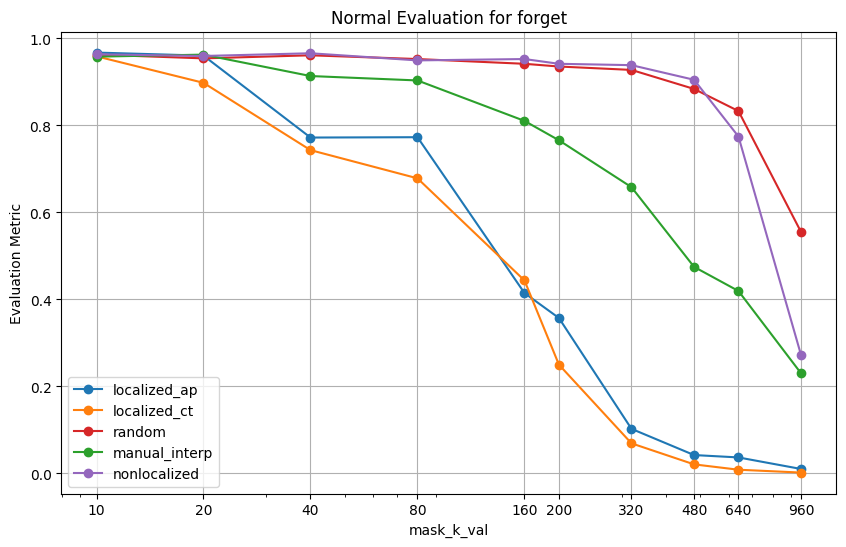

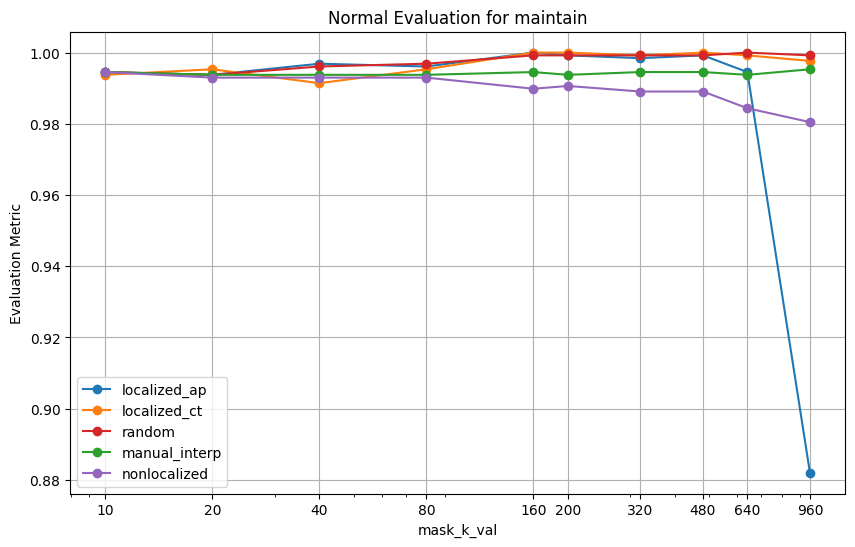

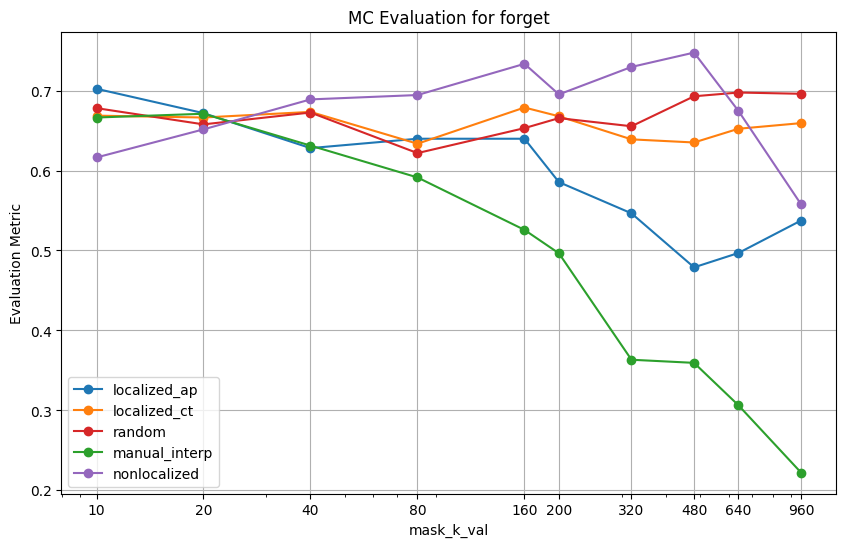

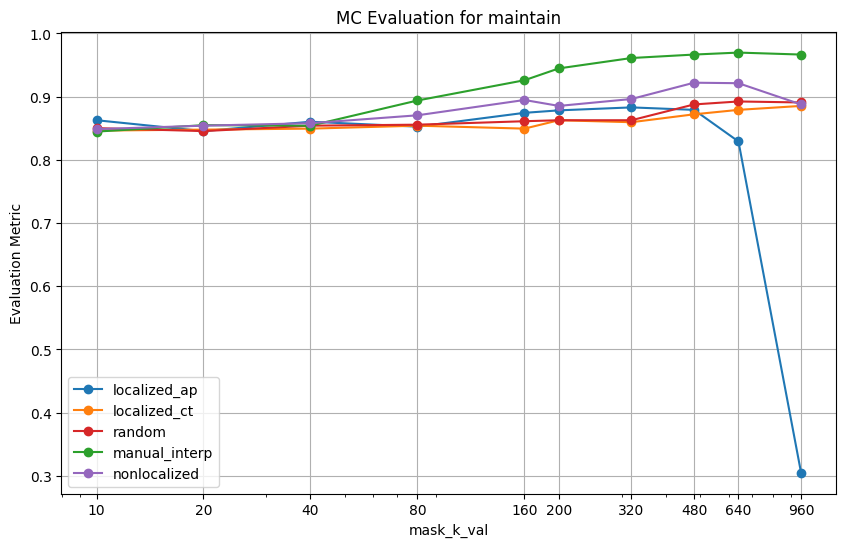

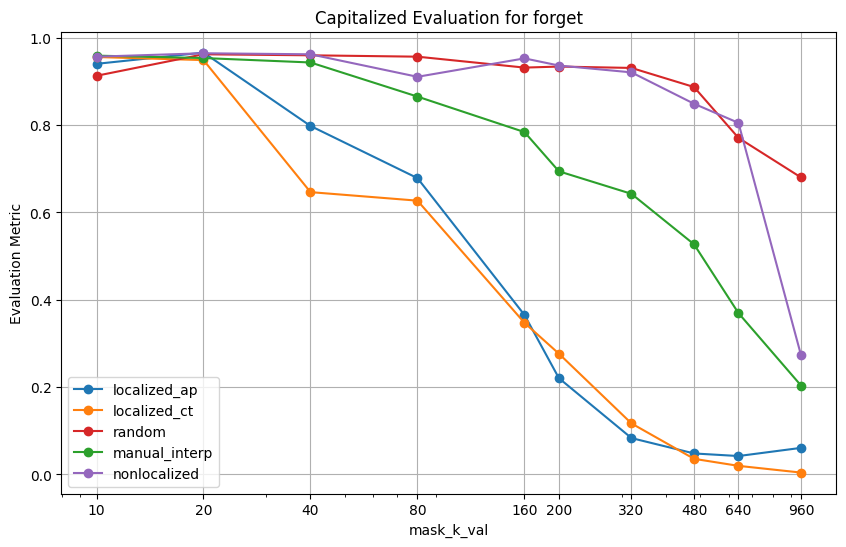

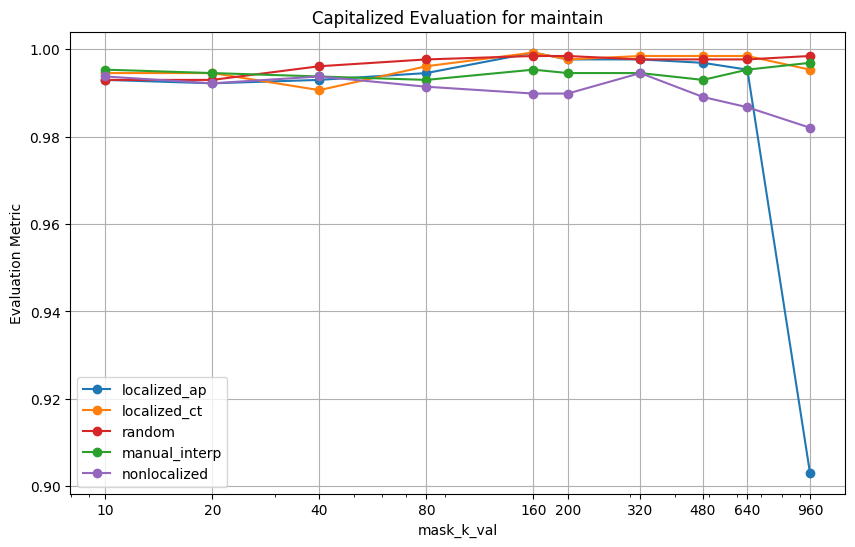

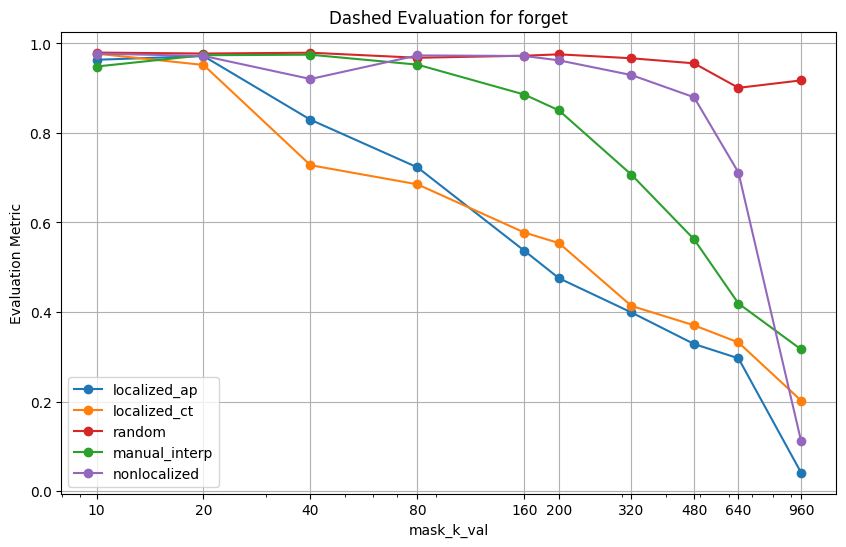

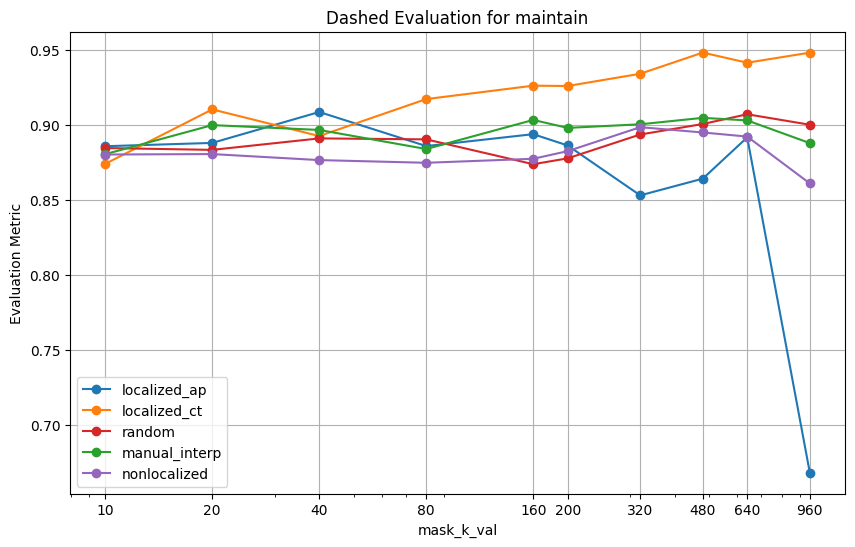

In [26]:
import pickle
beta=3
with open(f"results/neuron_cb_{beta=}_relearning_{n_relearn_iters=}_{n_relearn_athletes=}.pkl", "rb") as f:
    results = pickle.load(f)
import matplotlib.pyplot as plt
import numpy as np

color_scheme = {"localized_ap": "C0", "localized_ct": "C1", "manual_interp": "C2", "random": "C3", "nonlocalized": "C4"}


def plot_nested_evaluations_with_checks(all_evals, eval_type, nested_key, mask_k_vals=None):
    plt.figure(figsize=(10, 6))
    if mask_k_vals is None:
        mask_k_vals = sorted(next(iter(all_evals.values())).keys())  # Assuming all have the same k values

    for localization_type, evals in all_evals.items():
        scores = []
        for k in mask_k_vals:
            if eval_type in evals[k] and nested_key in evals[k][eval_type]:
                scores.append(evals[k][eval_type][nested_key])
            else:
                scores.append(None)  # or use -1 or np.nan
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o', color=color_scheme[localization_type])

    plt.xlabel('mask_k_val')
    plt.ylabel('Evaluation Metric')
    plt.title(f'{eval_type} Evaluation for {nested_key}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# Plotting regular evaluations
# for task in ['induction', 'pile', 'forget_sport', 'maintain_sport']:

# for task in list(localized_regular_evals.values())[0].keys():
#     plot_regular_evaluations(localized_regular_evals, nonlocalized_regular_evals, task, y_label=task)

# Plotting adversarial evaluations
for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
    for sport in ['forget', 'maintain']:
        plot_nested_evaluations_with_checks(relearning_adversarial_results, eval_type, sport, mask_k_vals=mask_k_vals)

### Scatterplots

In [ ]:
# scatterplot of neuron mask values, x_axis and y_axis are different localizations

def plot_